# Pre-Processing

Import necessary libraries

In [174]:
# dataframe and plotting libraries
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import math
from datetime import datetime

# pre-processing libraries
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# model libraries
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression

# statistics libraries
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

# neural net libraries
import torch
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from torchsummary import summary
from sklearn.neural_network import MLPRegressor

# import arima libraries
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.arima_model import ARIMA

In [505]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load in Main Dataframe and Correct to Right Format

In [176]:
path = '/content/HistoricalPrices.csv'
raw_df = pd.read_csv(path)
raw_df

,Date,Open,High,Low,Close
0,04/29/21,4206.14,4218.78,4176.81,4211.47
1,04/28/21,4185.14,4201.53,4181.78,4183.18
2,04/27/21,4188.25,4193.35,4176.22,4186.72
3,04/26/21,4185.03,4194.19,4182.36,4187.62
4,04/23/21,4138.78,4194.17,4138.78,4180.17
...,...,...,...,...,...
76,01/08/21,3815.05,3826.69,3783.60,3824.68
77,01/07/21,3764.71,3811.55,3764.71,3803.79
78,01/06/21,3712.20,3783.04,3705.34,3748.14
79,01/05/21,3698.02,3737.83,3695.07,3726.86


In [177]:
raw_df = raw_df[::-1] # invert dataframe
raw_df.set_index('Date', inplace=True) # set date to index
raw_df.rename(columns= {' Open': 'Open', ' High': 'High', ' Date': 'date', ' Low': 'Low', ' Close': 'Close'}, inplace=True) # rename_columns
raw_df

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Open,High,Low,Close
Date,,,,
01/04/21,3764.61,3769.99,3662.71,3700.65
01/05/21,3698.02,3737.83,3695.07,3726.86
01/06/21,3712.20,3783.04,3705.34,3748.14
01/07/21,3764.71,3811.55,3764.71,3803.79
01/08/21,3815.05,3826.69,3783.60,3824.68
...,...,...,...,...
04/23/21,4138.78,4194.17,4138.78,4180.17
04/26/21,4185.03,4194.19,4182.36,4187.62
04/27/21,4188.25,4193.35,4176.22,4186.72


Extract Additional Features:

In [178]:
# create feature column for each graph
def create_feature_cols(df, window):
  """
  This function creates sliding windows for the features we are considering.

  Input:
  * df (pandas dataframe; size: (n, 4)): dataframe of observed S&P 500 data for n days and 4 attributes (Open, High, Low, Close)
  * window (int): window size to consider for feature. For a day *i* and a window *w*,
                  we are looking to see if we can use data from day *i-w* to day *i - 1* to
                  predict the values for day *i*. 

  Output:
  # df (pandas dataframe; size: (n-window, 4 * (window+1))): dataframe of S&P 500 data for n days (first window days removed)
                                                            with the four original attributes, and the attributes of all window days
  """


  df = df.copy()
  feature_columns = ['Open', 'High', 'Low', 'Close']

  # shift all the indexes back up by 1 (repeat process for window length)
  for index in range(window):
    shift = index + 1
    for col in feature_columns:
      # shift and create column
      col_name = 'Day -' +str(shift) + ' ' + col
      series = df[col].shift(periods=shift)
      df[col_name] = series
  
  # drop first |window| rows due to incomplete data
  df = df[window:]
  return df

In [179]:
# set window size, then create dataframe for features with shifted window
window = 15
converted_df = create_feature_cols(raw_df, window)

# create base df to build inital model from
base_df = converted_df[:window]
base_df

,Open,High,Low,Close,Day -1 Open,Day -1 High,Day -1 Low,Day -1 Close,Day -2 Open,Day -2 High,Day -2 Low,Day -2 Close,Day -3 Open,Day -3 High,Day -3 Low,Day -3 Close,Day -4 Open,Day -4 High,Day -4 Low,Day -4 Close,Day -5 Open,Day -5 High,Day -5 Low,Day -5 Close,Day -6 Open,Day -6 High,Day -6 Low,Day -6 Close,Day -7 Open,Day -7 High,Day -7 Low,Day -7 Close,Day -8 Open,Day -8 High,Day -8 Low,Day -8 Close,Day -9 Open,Day -9 High,Day -9 Low,Day -9 Close,Day -10 Open,Day -10 High,Day -10 Low,Day -10 Close,Day -11 Open,Day -11 High,Day -11 Low,Day -11 Close,Day -12 Open,Day -12 High,Day -12 Low,Day -12 Close,Day -13 Open,Day -13 High,Day -13 Low,Day -13 Close,Day -14 Open,Day -14 High,Day -14 Low,Day -14 Close,Day -15 Open,Day -15 High,Day -15 Low,Day -15 Close
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
01/26/21,3862.96,3870.90,3847.78,3849.62,3851.68,3859.23,3797.16,3855.36,3844.24,3852.31,3830.41,3841.47,3857.46,3861.45,3845.05,3853.07,3816.22,3859.75,3816.22,3851.85,3781.88,3804.53,3780.37,3798.91,3788.73,3788.73,3749.62,3768.25,3814.98,3823.60,3792.86,3795.54,3802.23,3820.96,3791.50,3809.84,3801.62,3810.78,3776.51,3801.19,3803.14,3817.86,3789.02,3799.61,3815.05,3826.69,3783.60,3824.68,3764.71,3811.55,3764.71,3803.79,3712.20,3783.04,3705.34,3748.14,3698.02,3737.83,3695.07,3726.86,3764.61,3769.99,3662.71,3700.65
01/27/21,3836.83,3836.83,3732.48,3750.77,3862.96,3870.90,3847.78,3849.62,3851.68,3859.23,3797.16,3855.36,3844.24,3852.31,3830.41,3841.47,3857.46,3861.45,3845.05,3853.07,3816.22,3859.75,3816.22,3851.85,3781.88,3804.53,3780.37,3798.91,3788.73,3788.73,3749.62,3768.25,3814.98,3823.60,3792.86,3795.54,3802.23,3820.96,3791.50,3809.84,3801.62,3810.78,3776.51,3801.19,3803.14,3817.86,3789.02,3799.61,3815.05,3826.69,3783.60,3824.68,3764.71,3811.55,3764.71,3803.79,3712.20,3783.04,3705.34,3748.14,3698.02,3737.83,3695.07,3726.86
01/28/21,3755.75,3830.50,3755.75,3787.38,3836.83,3836.83,3732.48,3750.77,3862.96,3870.90,3847.78,3849.62,3851.68,3859.23,3797.16,3855.36,3844.24,3852.31,3830.41,3841.47,3857.46,3861.45,3845.05,3853.07,3816.22,3859.75,3816.22,3851.85,3781.88,3804.53,3780.37,3798.91,3788.73,3788.73,3749.62,3768.25,3814.98,3823.60,3792.86,3795.54,3802.23,3820.96,3791.50,3809.84,3801.62,3810.78,3776.51,3801.19,3803.14,3817.86,3789.02,3799.61,3815.05,3826.69,3783.60,3824.68,3764.71,3811.55,3764.71,3803.79,3712.20,3783.04,3705.34,3748.14
01/29/21,3778.05,3778.05,3694.12,3714.24,3755.75,3830.50,3755.75,3787.38,3836.83,3836.83,3732.48,3750.77,3862.96,3870.90,3847.78,3849.62,3851.68,3859.23,3797.16,3855.36,3844.24,3852.31,3830.41,3841.47,3857.46,3861.45,3845.05,3853.07,3816.22,3859.75,3816.22,3851.85,3781.88,3804.53,3780.37,3798.91,3788.73,3788.73,3749.62,3768.25,3814.98,3823.60,3792.86,3795.54,3802.23,3820.96,3791.50,3809.84,3801.62,3810.78,3776.51,3801.19,3803.14,3817.86,3789.02,3799.61,3815.05,3826.69,3783.60,3824.68,3764.71,3811.55,3764.71,3803.79
02/01/21,3731.17,3784.32,3725.62,3773.86,3778.05,3778.05,3694.12,3714.24,3755.75,3830.50,3755.75,3787.38,3836.83,3836.83,3732.48,3750.77,3862.96,3870.90,3847.78,3849.62,3851.68,3859.23,3797.16,3855.36,3844.24,3852.31,3830.41,3841.47,3857.46,3861.45,3845.05,3853.07,3816.22,3859.75,3816.22,3851.85,3781.88,3804.53,3780.37,3798.91,3788.73,3788.73,3749.62,3768.25,3814.98,3823.60,3792.86,3795.54,3802.23,3820.96,3791.50,3809.84,3801.62,3810.78,3776.51,3801.19,3803.14,3817.86,3789.02,3799.61,3815.05,3826.69,3783.60,3824.68
02/02/21,3791.84,3843.09,3791.84,3826.31,3731.17,3784.32,3725.62,3773.86,3778.05,3778.05,3694.12,3714.24,3755.75,3830.50,3755.75,3787.38,3836.83,3836.83,3732.48,3750.77,3862.96,3870.90,3847.78,3849.62,3851.68,3859.23,3797.16,3855.36,3844.24,3852.31,3830.41,3841.47,3857.46,3861.45,3845.05,3853.07,3816.22,3859.75,3816.22,3851.85,3781.88,3804.53,3780.37,3798.91,3788.73,3788.73,3749.62,3768.25,3814.98,3823.60,3792.86,3795.54,3802.23,3820.96,3791.50,3809.84,3801.62,3810.78,3776.51,3801.19,3803.14,3817.86,3789.02,3799.61
02/03/21,3840.27,3847.51,3816.68,3830.17

In [180]:
# list of features to consider
keep_features = list(set(converted_df.columns) - set(['Open', 'High', 'Low', 'Close']))
print(keep_features)

['Day -6 High', 'Day -10 High', 'Day -2 Low', 'Day -11 High', 'Day -11 Open', 'Day -6 Open', 'Day -10 Low', 'Day -8 High', 'Day -12 Close', 'Day -1 Low', 'Day -3 Close', 'Day -5 High', 'Day -15 Close', 'Day -7 Low', 'Day -6 Low', 'Day -6 Close', 'Day -11 Close', 'Day -7 Close', 'Day -13 Close', 'Day -4 Open', 'Day -10 Open', 'Day -13 High', 'Day -8 Low', 'Day -7 Open', 'Day -10 Close', 'Day -1 Open', 'Day -12 High', 'Day -14 Close', 'Day -3 High', 'Day -8 Open', 'Day -2 Open', 'Day -5 Close', 'Day -12 Open', 'Day -2 Close', 'Day -4 Low', 'Day -5 Open', 'Day -1 Close', 'Day -14 Open', 'Day -9 Open', 'Day -9 Close', 'Day -12 Low', 'Day -2 High', 'Day -9 High', 'Day -8 Close', 'Day -7 High', 'Day -1 High', 'Day -14 Low', 'Day -9 Low', 'Day -4 Close', 'Day -13 Low', 'Day -5 Low', 'Day -14 High', 'Day -3 Low', 'Day -13 Open', 'Day -15 Open', 'Day -15 High', 'Day -4 High', 'Day -11 Low', 'Day -15 Low', 'Day -3 Open']


Functions for Standardizing and Testing Models

In [181]:
# create scaling based on training data
lin_scaler = StandardScaler().fit(base_df[keep_features])

In [182]:
def obtain_predictions(df, window, open_model, high_model, close_model, low_model):
  """
  This function obtains the predictions for each attribute given a datafame

  Input:
  * df (pandas dataframe; size: (n, 4 * (window + 1))): dataframe of observed S&P 500 data  (with window features)
  * window (int): window size for training consideration
  * open_model (model): model for predicting the open value on a day  ... same for high model, close model, low model

  Output:
  * output_predictions (n-window, 1): dataframe of predictions of open values for all days in df not in window
  """

  open_predictions = open_model.predict(lin_scaler.transform(df[window:][keep_features]))
  high_predictions = high_model.predict(lin_scaler.transform(df[window:][keep_features]))
  close_predictions = close_model.predict(lin_scaler.transform(df[window:][keep_features]))
  low_predictions = low_model.predict(lin_scaler.transform(df[window:][keep_features]))
  return open_predictions, high_predictions, close_predictions, low_predictions

# Baseline Testing

Linear Model

In [183]:
# create a linear regression model for the given feature
def create_linear_model(feature, df):
  X_train = lin_scaler.transform(df[keep_features])
  y_train = df[feature]

  model = LinearRegression()
  model.fit(X_train, y_train)
  return model

In [184]:
# create a model for each attribute
linear_open_model = create_linear_model('Open', base_df)
linear_high_model = create_linear_model('High', base_df)
linear_low_model = create_linear_model('Low', base_df)
linear_close_model = create_linear_model('Close', base_df)

In [185]:
# obtain results
linear_result = obtain_predictions(converted_df, window, linear_open_model, linear_high_model, linear_close_model, linear_low_model)

SGD (Without Updates)

In [186]:
def create_basic_SGD_model(feature, df):
  X_train = lin_scaler.transform(df[keep_features])
  y_train = df[feature]

  model =  SGDRegressor()
  model.fit(X_train, y_train)
  return model

In [187]:
basic_SGD_open_model = create_basic_SGD_model('Open', base_df)
basic_SGD_high_model = create_basic_SGD_model('High', base_df)
basic_SGD_close_model = create_basic_SGD_model('Close', base_df)
basic_SGD_low_model = create_basic_SGD_model('Low', base_df)

In [188]:
basic_SGD_result = obtain_predictions(converted_df, window, basic_SGD_open_model, basic_SGD_high_model, basic_SGD_close_model, basic_SGD_low_model)

SGD (with Single Updates)

In [189]:
single_update_SGD_open_model = create_basic_SGD_model('Open', base_df)
single_update_SGD_high_model = create_basic_SGD_model('High', base_df)
single_update_SGD_close_model = create_basic_SGD_model('Close', base_df)
single_update_SGD_low_model = create_basic_SGD_model('Low', base_df)

In [190]:
def predictions_with_single_update(df, window, open_model, high_model, close_model, low_model, weight=None):
  """
  This function obtains the predictions for each attribute given a datafame. Unlike the previous model,
  for each prediction it obtains, it also updates the model, once per day.

  Input:
  * df (pandas dataframe; size: (n, 4 * (window + 1))): dataframe of observed S&P 500 data  (with window features)
  * window (int): window size for training consideration
  * open_model (model): model for predicting the open value on a day  ... same for high model, close model, low model
  * weight: weight applied to sampele

  Output:
  * output_predictions (n-window, 1): dataframe of predictions of open values for all days in df not in window,
  """

  copy_df = df.copy()

  open_predictions = []
  high_predictions = []
  close_predictions = []
  low_predictions = []

  # perform predictions one-by-one
  for i in range(window, copy_df.shape[0]):
    row_df = copy_df.iloc[[i]]

    # for day i, obtain the prediction from the model and append to predictions
    X = lin_scaler.transform(row_df[keep_features])

    y_open = open_model.predict(X)
    y_high = high_model.predict(X)
    y_close = close_model.predict(X)
    y_low = low_model.predict(X)

    open_predictions.append(y_open[0])
    high_predictions.append(y_high[0])
    low_predictions.append(y_low[0])
    close_predictions.append(y_close[0])

    # update day i's data into the model to be used for day i+1 and beyond
    if weight is not None:
      open_model.partial_fit(X, np.ravel(row_df[['Open']]), sample_weight=weight)  
      high_model.partial_fit(X, np.ravel(row_df[['High']]), sample_weight=weight)  
      low_model.partial_fit(X, np.ravel(row_df[['Low']]), sample_weight=weight)  
      close_model.partial_fit(X, np.ravel(row_df[['Close']]), sample_weight=weight)
    else:
      open_model.partial_fit(X, np.ravel(row_df[['Open']]))  
      high_model.partial_fit(X, np.ravel(row_df[['High']]))  
      low_model.partial_fit(X, np.ravel(row_df[['Low']]))  
      close_model.partial_fit(X, np.ravel(row_df[['Close']]))

  return open_predictions, high_predictions, close_predictions, low_predictions

In [191]:
single_update_SGD_result = predictions_with_single_update(converted_df, window, single_update_SGD_open_model, single_update_SGD_high_model,
                                                          single_update_SGD_close_model, single_update_SGD_low_model, 0.2)

SGD (with batch updates of 1 week)

In [192]:
batch_update_SGD_open_model = create_basic_SGD_model('Open', base_df)
batch_update_SGD_high_model = create_basic_SGD_model('High', base_df)
batch_update_SGD_close_model = create_basic_SGD_model('Close', base_df)
batch_update_SGD_low_model = create_basic_SGD_model('Low', base_df)

In [193]:
def predictions_with_batch_update(df, window, open_model, high_model, close_model, low_model, weight=None):
  """
  This function obtains the predictions for each attribute given a datafame. Unlike the previous model,
  for each prediction it obtains, it also updates the model, once per week.

  Input:
  * df (pandas dataframe; size: (n, 4 * (window + 1))): dataframe of observed S&P 500 data  (with window features)
  * window (int): window size for training consideration
  * open_model (model): model for predicting the open value on a day  ... same for high model, close model, low model
  * weight: weight applied to sampele

  Output:
  * output_predictions (n-window, 1): dataframe of predictions of open values for all days in df not in window,
  """

  copy_df = df.copy()

  open_predictions = []
  high_predictions = []
  close_predictions = []
  low_predictions = []

  # perform predictions one by one
  for i in range(window, copy_df.shape[0]):
    row_df = copy_df.iloc[[i]]

    # for day i, obtain the prediction from the model and append to predictions
    X = lin_scaler.transform(row_df[keep_features])

    y_open = open_model.predict(X)
    y_high = high_model.predict(X)
    y_close = close_model.predict(X)
    y_low = low_model.predict(X)

    open_predictions.append(y_open[0])
    high_predictions.append(y_high[0])
    low_predictions.append(y_low[0])
    close_predictions.append(y_close[0])

    # update the model in a batch, in this case, the batch is once every 5 days (week)
    if (i > 0 and i % 4 == 0):
      X = lin_scaler.transform(copy_df[keep_features].iloc[i-1:i+4])
      if weight:
        open_model.partial_fit(X, np.ravel(copy_df[['Open']].iloc[i-1:i+4]), sample_weight=weight)  
        high_model.partial_fit(X, np.ravel(copy_df[['High']].iloc[i-1:i+4]), sample_weight=weight)  
        low_model.partial_fit(X, np.ravel(copy_df[['Low']].iloc[i-1:i+4]), sample_weight=weight)  
        close_model.partial_fit(X, np.ravel(copy_df[['Close']].iloc[i-1:i+4]), sample_weight=weight)
      else:
        open_model.partial_fit(X, np.ravel(copy_df[['Open']].iloc[i-1:i+4]))  
        high_model.partial_fit(X, np.ravel(copy_df[['High']].iloc[i-1:i+4]))  
        low_model.partial_fit(X, np.ravel(copy_df[['Low']].iloc[i-1:i+4]))  
        close_model.partial_fit(X, np.ravel(copy_df[['Close']].iloc[i-1:i+4]))

  return open_predictions, high_predictions, close_predictions, low_predictions

In [194]:
batch_update_SGD_result = predictions_with_batch_update(converted_df, window, batch_update_SGD_open_model, batch_update_SGD_high_model,
                                                          batch_update_SGD_close_model, batch_update_SGD_low_model, 0.2)

MLP Regressor (Single Update)

In [195]:
# create a linear regression model for the given feature
def create_basic_MLP_model(feature, df):
  X_train = lin_scaler.transform(df[keep_features])
  y_train = df[feature]

  model = MLPRegressor(hidden_layer_sizes=(50, 50, 25, 15), random_state=42, max_iter=1000)
  model.fit(X_train, y_train)
  return model

In [196]:
single_update_MLP_open_model = create_basic_MLP_model('Open', base_df)
single_update_MLP_high_model = create_basic_MLP_model('High', base_df)
single_update_MLP_close_model = create_basic_MLP_model('Close', base_df)
single_update_MLP_low_model = create_basic_MLP_model('Low', base_df)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [197]:
single_update_MLP_result = predictions_with_single_update(converted_df, window, single_update_MLP_open_model, single_update_MLP_high_model,
                                                          single_update_MLP_close_model, single_update_MLP_low_model)

MLP Regressor (Batch Update)

In [198]:
batch_update_MLP_open_model = create_basic_MLP_model('Open', base_df)
batch_update_MLP_high_model = create_basic_MLP_model('High', base_df)
batch_update_MLP_close_model = create_basic_MLP_model('Close', base_df)
batch_update_MLP_low_model = create_basic_MLP_model('Low', base_df)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [199]:
batch_update_MLP_result = predictions_with_single_update(converted_df, window, batch_update_MLP_open_model, batch_update_MLP_high_model,
                                                          batch_update_MLP_close_model, batch_update_MLP_low_model)

# Baseline Comparisons

In [200]:
def plot_comparisons(feature, index):
  """
  This function plots the predictions for a given feature.

  Input:
  * feature (string): attribute to consider
  * index (int): index corresponding to attribute to consider {0: Open, 1: High, 2: Close, 3: Low}
  """

  x = [i for i in range(converted_df[window:].shape[0])]
  sns.set(rc={'figure.figsize':(15,8)})
  sns.lineplot(x=x, y=converted_df[window: converted_df.shape[0]][feature], label='Actual')
  sns.lineplot(x=x, y=linear_result[index], label='Linear')
  sns.lineplot(x=x, y=basic_SGD_result[index], label='Basic SGD')
  sns.lineplot(x=x, y=single_update_SGD_result[index], label='Single Update SGD')
  sns.lineplot(x=x, y=batch_update_SGD_result[index], label='Batch Update SGD')
  #sns.lineplot(x=x, y=single_update_MLP_result[index], label='Single Update MLP')
  #sns.lineplot(x=x, y=batch_update_MLP_result[index], label='Batch Update MLP')

  plt.title(feature + " Predictions")
  plt.ylabel("Dollars")
  plt.xlabel("Days since 02/27/2021")

In [201]:
def RMSE_comparisons(feature, index):
  """
  Print all the RMSE comparisons

  Input:
  * feature (string): attribute to consider
  * index (int): index corresponding to attribute to consider {0: Open, 1: High, 2: Close, 3: Low}
  """

  actual = converted_df[window: converted_df.shape[0]][feature].values
  print("Linear RMSE:", math.sqrt(mean_squared_error(actual, linear_result[index])))
  print("Basic SGD RMSE:", math.sqrt(mean_squared_error(actual, basic_SGD_result[index])))
  print("Single Update SGD RMSE:", math.sqrt(mean_squared_error(actual, single_update_SGD_result[index])))
  print("Batch Update SGD RMSE:", math.sqrt(mean_squared_error(actual, batch_update_SGD_result[index])))
  print("Single Update MLP RMSE:", math.sqrt(mean_squared_error(actual, single_update_MLP_result[index])))
  print("Batch Update MLP RMSE:", math.sqrt(mean_squared_error(actual, batch_update_MLP_result[index])))

Linear RMSE: 201.0500231498656
Basic SGD RMSE: 207.2445637984015
Single Update SGD RMSE: 53.531939799457646
Batch Update SGD RMSE: 45.04024556438502
Single Update MLP RMSE: 1249.007012054145
Batch Update MLP RMSE: 1249.007012054145


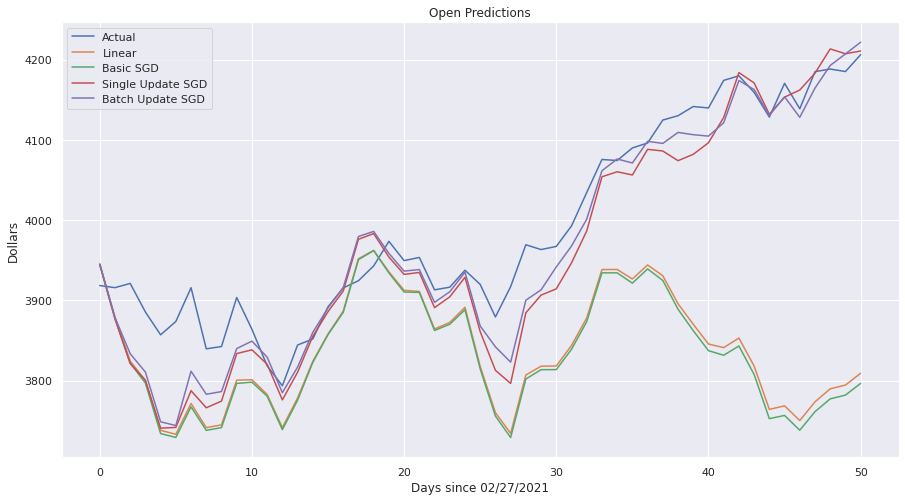

In [202]:
RMSE_comparisons('Open', 0)
plot_comparisons('Open', 0)

Linear RMSE: 195.49091755648163
Basic SGD RMSE: 188.23756083807658
Single Update SGD RMSE: 56.50364435455879
Batch Update SGD RMSE: 51.552675460575415
Single Update MLP RMSE: 1244.6424657251066
Batch Update MLP RMSE: 1244.6424657251066


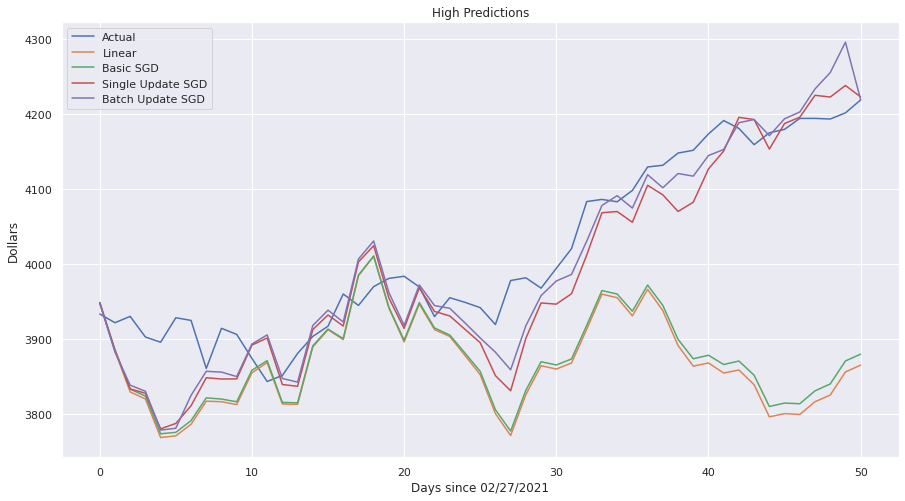

In [203]:
RMSE_comparisons('High', 1)
plot_comparisons('High', 1)

Linear RMSE: 263.67319782734654
Basic SGD RMSE: 257.64806785511723
Single Update SGD RMSE: 90.62086256319711
Batch Update SGD RMSE: 77.69663093428495
Single Update MLP RMSE: 1230.5597994624118
Batch Update MLP RMSE: 1230.5597994624118


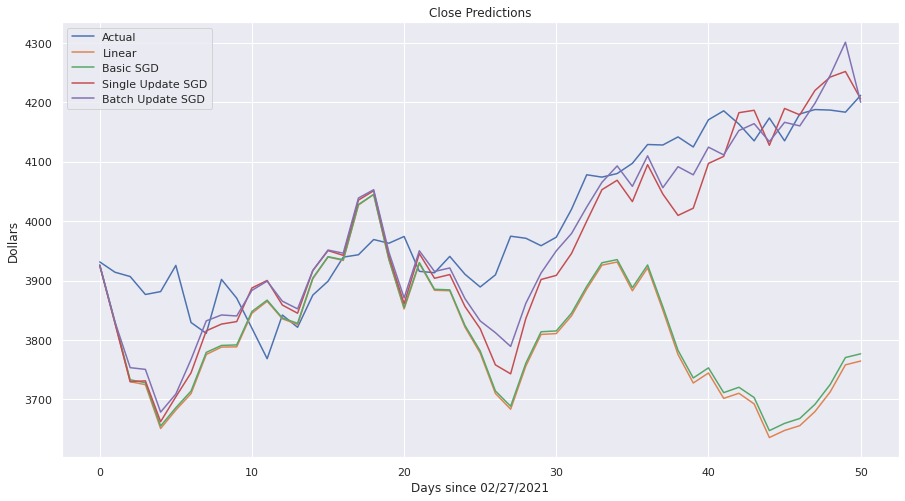

In [204]:
RMSE_comparisons('Close', 2)
plot_comparisons('Close', 2)

Linear RMSE: 294.6878263174156
Basic SGD RMSE: 288.47373605386207
Single Update SGD RMSE: 89.68336865004332
Batch Update SGD RMSE: 78.76323175548681
Single Update MLP RMSE: 1228.199659649909
Batch Update MLP RMSE: 1228.199659649909


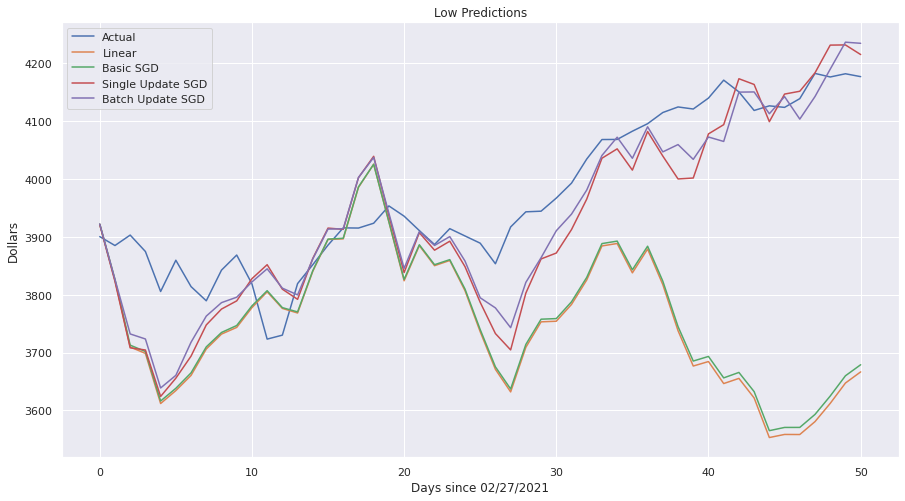

In [205]:
RMSE_comparisons('Low', 3)
plot_comparisons('Low', 3)

In [206]:
def RMSE_results(results_list, names_list):
  """
  This function outputs the RMSEs for each attribute and method in table format.

  Input:
  * results_list (lists of lists): results list
  * names_list (list of string): list of names techniques

  Output
  * weightes_RMSEs_df (pandas DataFrame): pandas dataframe of methods and attributes
  """

  RMSEs_open = []
  RMSEs_high = []
  RMSEs_close = []
  RMSEs_low = []

  # get actual values
  open_actual = converted_df[window: converted_df.shape[0]]['Open'].values
  high_actual = converted_df[window: converted_df.shape[0]]['High'].values
  low_actual = converted_df[window: converted_df.shape[0]]['Low'].values
  close_actual = converted_df[window: converted_df.shape[0]]['Close'].values

  # for each of the results, get open, high, close, low
  for results in results_list:
    RMSEs_open.append(math.sqrt(mean_squared_error(open_actual, results[0])))
    RMSEs_high.append(math.sqrt(mean_squared_error(high_actual, results[1])))
    RMSEs_close.append(math.sqrt(mean_squared_error(close_actual, results[2])))
    RMSEs_low.append(math.sqrt(mean_squared_error(low_actual, results[3])))
  
  # create dataframe
  weights_RMSEs_df = pd.DataFrame([RMSEs_open, RMSEs_high, RMSEs_close, RMSEs_low],
                                  columns=names_list)
  weights_RMSEs_df = weights_RMSEs_df.append(weights_RMSEs_df.mean(axis=0), ignore_index=True)
  weights_RMSEs_df.index = ['Open', 'High', 'Close', 'Low', 'Average']
  return weights_RMSEs_df.round(2)

In [207]:
method_results = [linear_result, basic_SGD_result, single_update_SGD_result, batch_update_SGD_result,
                  single_update_MLP_result, batch_update_MLP_result]
method_lists = ['Linear', 'Basic SGD', 'Single SGD', 'Batch SGD', 'Single MLP', 'Batch MLP']
RMSE_results(method_results, method_lists)

,Linear,Basic SGD,Single SGD,Batch SGD,Single MLP,Batch MLP
Open,201.05,207.24,53.53,45.04,1249.01,1249.01
High,195.49,188.24,56.50,51.55,1244.64,1244.64
Close,263.67,257.65,90.62,77.70,1230.56,1230.56
Low,294.69,288.47,89.68,78.76,1228.20,1228.20
Average,238.73,235.40,72.58,63.26,1238.10,1238.10


# Tuning Batch Update
The Batch Update SGD appeared to perform the best, so we run several additional tests to tune the hyperparameter setting of the model.  In addition, we also want to test the sample weight of the sample_weight.  However, since the partial fit occurs sequentially, we can't do cross-validation, and so it's better to jsut run things sequentially.

Try Different Sample Weight Values

In [208]:
# attempt differnt sample weights
sample_weights = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 0.9, 1]
sample_weights_results = []
for weight in sample_weights:
  update_SGD_open_model = create_basic_SGD_model('Open', base_df)
  update_SGD_high_model = create_basic_SGD_model('High', base_df)
  update_SGD_close_model = create_basic_SGD_model('Close', base_df)
  update_SGD_low_model = create_basic_SGD_model('Low', base_df)
  result = predictions_with_batch_update(converted_df, window, update_SGD_open_model, update_SGD_high_model,
                                        update_SGD_close_model, update_SGD_low_model, 0.2)
  sample_weights_results.append(result)

In [209]:
RMSE_results(sample_weights_results, sample_weights)

,0.01,0.05,0.10,0.20,0.30,0.40,0.50,0.75,0.90,1.00
Open,45.38,47.34,45.53,44.59,46.37,43.09,46.46,43.13,42.31,47.18
High,51.21,51.31,48.44,51.57,49.97,49.05,48.99,49.17,50.66,50.03
Close,78.23,78.76,78.55,80.94,81.57,78.73,80.98,81.28,76.27,77.23
Low,77.81,78.68,79.09,77.00,78.82,77.50,77.08,76.96,76.58,76.77
Average,63.15,64.02,62.90,63.52,64.18,62.09,63.38,62.63,61.46,62.80


# SGD Batch Forecasting

In [210]:
def SGD_forecast(df, feature, window, forecast_window, open_model, high_model, close_model, low_model):
  """
  This function creates a forecast for the S&P 500 values for each of the attributes

  Input:
  * df (pandas dataframe; size: (n, 4 * (window + 1))): dataframe of observed S&P 500 data  (with window features)
  * feature (size): attribute to predict for
  * window (int): window size for training consideration
  * forecast (int): forecast window to predict for
  * open_model (model): model for predicting the open value on a day  ... same for high model, close model, low model

  Output:
  * output_predictions (pandas dataframe; size: (forecast_window, 4)): dataframe of forecasts for each day in the forecast window for each attribute
  """
  
  copy_df = df.copy()
  predictions_table = []

  # for each day in the forecast index, attempt to create a prediction
  for forecast_index in range(forecast_window):
    forecast_features = []
    # need to obtain features for days i-1, i-2, i..., i- window for each of the four attribute
    for back_index in range(window):
      # if value for the past days exists from training data, use real value
      try:
        access_index = df.shape[0] + forecast_index - (back_index + 1)
        back_row = copy_df.iloc[[access_index]]
        forecast_features.append(back_row['Open'][0])
        forecast_features.append(back_row['High'][0])
        forecast_features.append(back_row['Low'][0])
        forecast_features.append(back_row['Close'][0])
      # if value for past days does not exist from training data, use a prediction value
      except:
        access_index = forecast_index - (back_index + 1)
        back_row = predictions_table[access_index]
        forecast_features.append(back_row[0])
        forecast_features.append(back_row[1])
        forecast_features.append(back_row[2])
        forecast_features.append(back_row[3])

    # obtain predictions
    scaled_features = lin_scaler.transform(pd.DataFrame(forecast_features).T)
    open_prediction = open_model.predict(scaled_features)[0]
    high_prediction = high_model.predict(scaled_features)[0]
    close_prediction = close_model.predict(scaled_features)[0]
    low_prediction = low_model.predict(scaled_features)[0]
    row_predictions = [open_prediction, high_prediction, low_prediction, close_prediction]

    # add new prediction to be used for future predictions
    predictions_table.append(row_predictions)
  
  # output prediction
  output_df = pd.DataFrame(predictions_table, columns=['Open', 'High', 'Low', 'Close'])
  return output_df

In [211]:
SGD_single_fc = SGD_forecast(converted_df, 'Open', 15, 15, single_update_SGD_open_model, single_update_SGD_high_model, single_update_SGD_close_model, single_update_SGD_low_model)
SGD_batch_fc = SGD_forecast(converted_df, 'Open', 15, 15, batch_update_SGD_open_model, batch_update_SGD_high_model, batch_update_SGD_close_model, batch_update_SGD_low_model)

In [212]:
SGD_batch_fc

,Open,High,Low,Close
0,4186.637704,4175.062992,4153.060524,4138.978289
1,4195.733392,4194.392296,4191.341854,4177.361344
2,4185.228707,4176.225634,4154.441639,4141.074046
3,4167.926044,4172.507053,4164.505411,4154.169518
4,4201.727517,4197.045547,4205.821044,4187.132982
5,4187.421625,4195.375451,4198.672688,4183.072927
6,4193.489324,4191.715748,4187.688625,4170.393772
7,4212.762734,4218.304747,4224.186079,4202.287224
8,4198.307609,4202.385452,4189.261167,4171.543358
9,4206.968114,4208.472566,4211.145977,4191.379728


# ARIMA Forecasting

Build ARIMA Model for forecasting

In [213]:
def build_ARIMA_model(df, validate_window, forecast_window, feature, p, q, d):
  """
  This function creates an ARIMA model for forecasting

  Input:
  * df (pandas dataframe; size: (n, 4 * (window + 1))): dataframe of observed S&P 500 data  (with window features)
  * feature (size): attribute to predict for
  * validate_window (int): window size for analyzing the validation of ARIMA model (training data exists here)
  * forecast_window (int): forecast window to predict for
  * p (int): number of autoregressive terms
  * q (int): number of nonseasonal differences needed for stationarity
  * r (int): number of lagged forecast errors in the prediction equation

  Output:
  * v_fc (lsit; size of validate window): feature prediction values for validation window
  * v_lower_series (panda series): lower series (95% confidence interval) for validation predictions
  * v_upper_series (panda series): upper series (95% confidence interval) for validation predictions
  * f_fc (list; size of validate window): feature prediction values for forecasts window
  * f_lower_series (panda series): lower series (95% confidence interval) for forecasts
  * f_upper_series (panda series): upper series (95% confidence interval) for forecasts
  """

  # split training data into training and validation
  ARIMA_train = df[feature][:-validate_window]
  ARIMA_validate = df[feature][-validate_window:]

  # create a validation model based on only the split training data
  validate_model = ARIMA(ARIMA_train, order=(p,q,d))
  validate_fitted = validate_model.fit()
  v_fc, v_se, v_conf = validate_fitted.forecast(validate_window, alpha=0.05)

  v_lower_series = pd.Series(v_conf[:, 0], index=ARIMA_validate.index)
  v_upper_series = pd.Series(v_conf[:, 1], index=ARIMA_validate.index)

  # create model on all training data (not split into training and validation)
  ARIMA_train = df[feature]
  ARIMA_model = ARIMA(ARIMA_train, order=(p, q, d))
  ARIMA_fitted = ARIMA_model.fit()
  f_fc, f_se, f_conf = ARIMA_fitted.forecast(forecast_window, alpha=0.05)
  f_lower_series = pd.Series(f_conf[:, 0], index=ARIMA_validate.index)
  f_upper_series = pd.Series(f_conf[:, 1], index=ARIMA_validate.index)

  return v_fc, v_lower_series, v_upper_series, f_fc, f_lower_series, f_upper_series

In [214]:
# get the forecasts and validation from 
open_v, open_v_lower, open_v_upper, open_fc, open_f_lower, open_f_upper = build_ARIMA_model(converted_df, window, window, 'Open', 2, 1, 1)
high_v, high_v_lower, high_v_upper, high_fc, high_f_lower, high_f_upper = build_ARIMA_model(converted_df, window, window, 'High', 2, 1, 1)
close_v, close_v_lower, close_v_upper, close_fc, close_f_lower, close_f_upper = build_ARIMA_model(converted_df, window, window, 'Close', 2, 1, 1)
low_v, low_v_lower, low_v_upper, low_fc, low_f_lower, low_f_upper = build_ARIMA_model(converted_df, window, window, 'Low', 2, 1, 1)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

# ARIMA vs SGD Forecasting

In [215]:
def plot_ARIMA(df, validate_window, forecast_window, feature,
               validate, v_upper_series, v_lower_series,
               single_SGD_validate, batch_SGD_validate,
               ARIMA_fc, f_upper_series, f_lower_series,
               single_SGD_fc, batch_SGD_fc):
  """
  This function creates plotting for validation window and forecasts

  Input:
  * df (pandas dataframe; size: (n, 4 * (window + 1))): dataframe of observed S&P 500 data  (with window features)
  * feature (size): attribute to predict for
  * validate (list): predictions for validate window based on ARIMA
  * lower_series (panda series): lower series (95% confidence interval) for validation predictions
  * upper_series (panda series): upper series (95% confidence interval) for validation predictions
  * single_SGD_validate (list): predictions for validate window based on single SGD 
  * batch_SGD_validate (list): predictions for validate window based on batch SGD
  * ARIMA_SGD_fc (list): forecasts for forecast window based on ARIMA
  * single_SGD_fc (list): forecasts for forecast window based on single SGD 
  * batch_SGD_fc (list): forecasts for forecast window based on batch SGD
  """


  plt.figure(figsize=(15,8))

  # training
  ARIMA_train = df[feature][:-validate_window]
  ARIMA_test = df[feature][-validate_window:]

  # validate
  ARIMA_validate = df[feature][-validate_window:]
  single_SGD_validate = single_SGD_validate[-validate_window:]
  batch_SGD_validate = batch_SGD_validate[-validate_window:]

  # future forecast
  single_fc = single_SGD_fc[feature]
  batch_fc = batch_SGD_fc[feature]


  # set ranges of validation and forecasts windows
  validate_beg = df[:-validate_window].shape[0]
  validate_end = df.shape[0]
  forecast_beg = validate_end
  forecast_end = validate_end + forecast_window

  x = [i for i in range(df[:-validate_window].shape[0])]
  validate_range = list(range(validate_beg, validate_end))
  forecast_range = list(range(forecast_beg, forecast_end))

  sns.set(rc={'figure.figsize':(15,8)})
  sns.lineplot(x=x, y=ARIMA_train, label='Actual Training')

  # plot actual
  sns.lineplot(x=validate_range, y=ARIMA_test, label='Actual Validate')

  # plot validation
  plt.fill_between(validate_range, v_lower_series, v_upper_series, color='silver', alpha=.15, label='Validate Confidence Interval')
  sns.lineplot(x=validate_range, y=single_SGD_validate, label='Single SGD Validate')
  sns.lineplot(x=validate_range, y=batch_SGD_validate, label='Batch SGD Validate')
  sns.lineplot(x=validate_range, y=validate, label='ARIMA Validate')

  # plot forecasts
  sns.lineplot(x=forecast_range, y=ARIMA_fc, label ='ARIMA Forecast')
  sns.lineplot(x=forecast_range, y=single_fc, label = 'Single SGD Forecast')
  sns.lineplot(x=forecast_range, y=batch_fc, label = 'Batch SGD Forecast')
  plt.fill_between(forecast_range, f_lower_series, f_upper_series, color='gray', alpha=.15, label='Forecast Confidence Interval')

  plt.legend()
  plt.title("Forecase for " + feature)
  plt.ylabel("Dollars")
  plt.xlabel("Days since 02/27/21")

Plot Forecasts

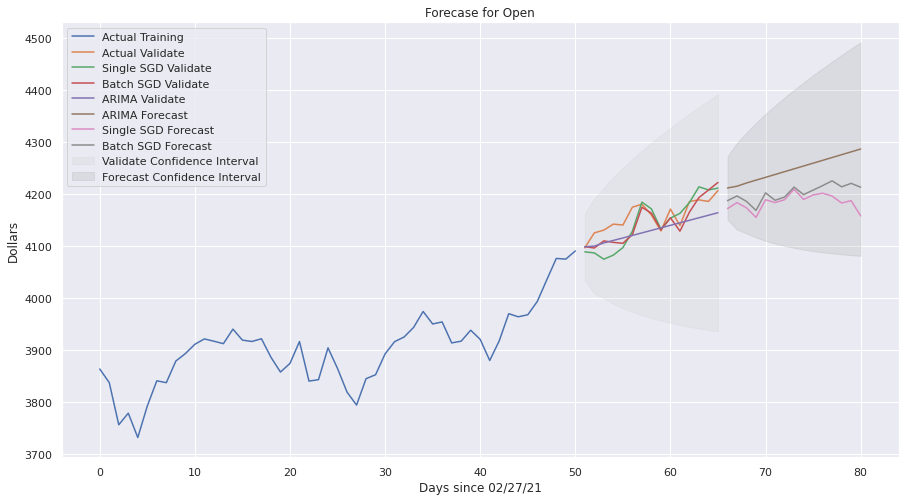

In [216]:
plot_ARIMA(converted_df, window, 15, 'Open',
          open_v, open_v_lower, open_v_upper,
          single_update_SGD_result[0],
          batch_update_SGD_result[0],
          open_fc, open_f_lower, open_f_upper,
          SGD_single_fc, SGD_batch_fc)

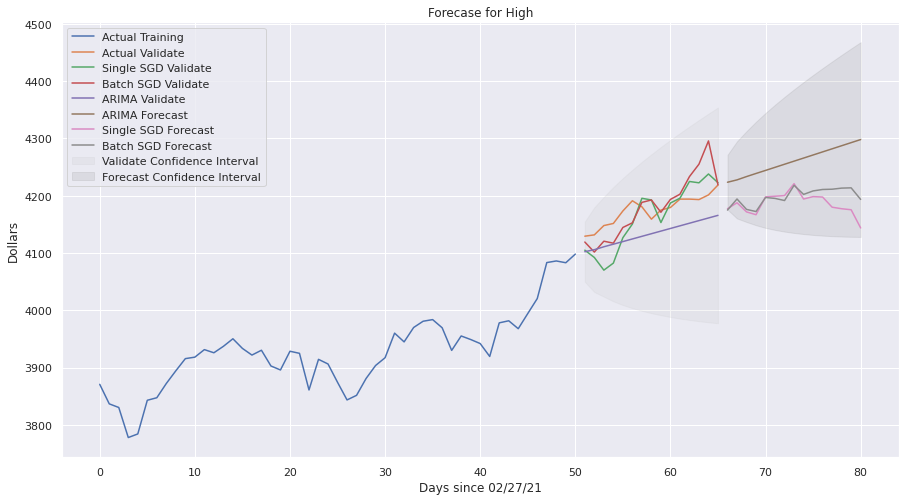

In [217]:
plot_ARIMA(converted_df, window, 15, 'High',
          high_v, high_v_lower, high_v_upper,
          single_update_SGD_result[1],
          batch_update_SGD_result[1],
          high_fc, high_f_lower, high_f_upper,
          SGD_single_fc, SGD_batch_fc)

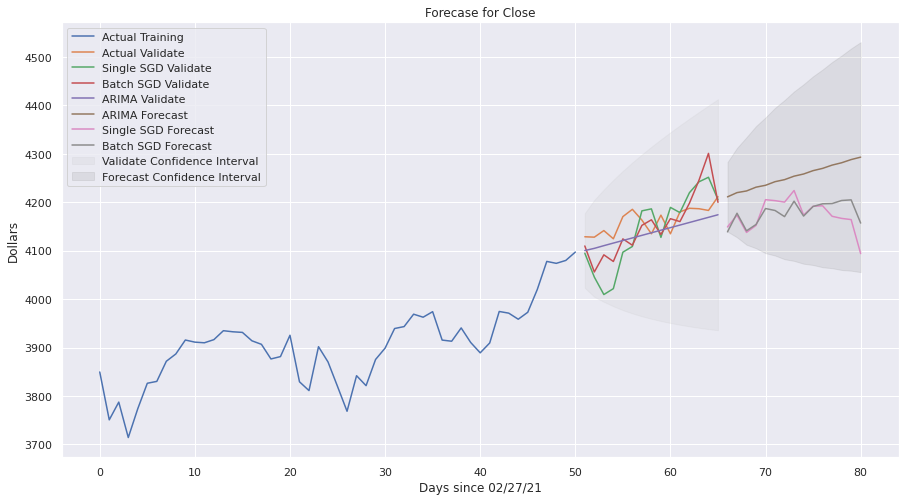

In [218]:
plot_ARIMA(converted_df, window, 15, 'Close',
          close_v, close_v_lower, close_v_upper,
          single_update_SGD_result[2],
          batch_update_SGD_result[2],
          close_fc, close_f_lower, close_f_upper,
          SGD_single_fc, SGD_batch_fc)

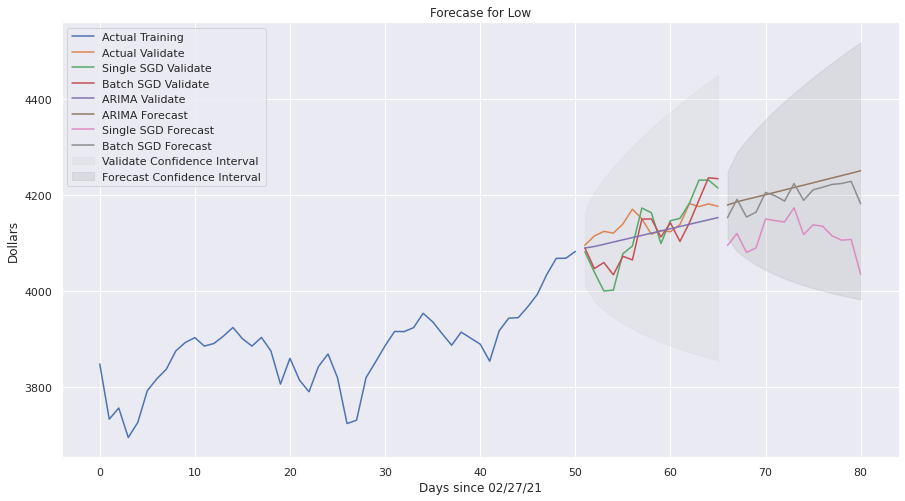

In [219]:
plot_ARIMA(converted_df, window, 15, 'Low',
          low_v, low_v_lower, low_v_upper,
          single_update_SGD_result[3],
          batch_update_SGD_result[3],
          low_fc, low_f_lower, low_f_upper,
          SGD_single_fc, SGD_batch_fc)

RMSE

In [224]:
def validate_RMSE_results(results_list, names_list, validate_window):
  """
  This function outputs the RMSEs for each attribute and method in table format.

  Input:
  * results_list (lists of lists): results list
  * names_list (list of string): list of names techniques
  * validate_window (int): validate window length

  Output
  * weightes_RMSEs_df (pandas DataFrame): pandas dataframe of methods and attributes
  """

  RMSEs_open = []
  RMSEs_high = []
  RMSEs_close = []
  RMSEs_low = []

  # get actual values
  open_actual = converted_df[-validate_window:]['Open'].values
  high_actual = converted_df[-validate_window:]['High'].values
  low_actual = converted_df[-validate_window:]['Low'].values
  close_actual = converted_df[-validate_window:]['Close'].values


  # for each of the results, get open, high, close, low
  for results in results_list:
    RMSEs_open.append(math.sqrt(mean_squared_error(open_actual, results[0])))
    RMSEs_high.append(math.sqrt(mean_squared_error(high_actual, results[1])))
    RMSEs_close.append(math.sqrt(mean_squared_error(close_actual, results[2])))
    RMSEs_low.append(math.sqrt(mean_squared_error(low_actual, results[3])))

  # create dataframe
  weights_RMSEs_df = pd.DataFrame([RMSEs_open, RMSEs_high, RMSEs_close, RMSEs_low],
                                  columns=names_list)                  
  weights_RMSEs_df = weights_RMSEs_df.append(weights_RMSEs_df.mean(axis=0), ignore_index=True)
  weights_RMSEs_df.index = ['Open', 'High', 'Close', 'Low', 'Average']
  
  return weights_RMSEs_df

In [225]:
validate_ARIMA_result = [open_v, high_v, close_v, low_v]
validate_single_SGD_result = [single_update_SGD_result[i][-15:] for i in range(4)]
validate_batch_SGD_result = [batch_update_SGD_result[i][-15:] for i in range(4)]
validate_results = [validate_ARIMA_result, validate_single_SGD_result, validate_batch_SGD_result]
validate_lists = ['ARIMA', 'Single SGD', 'Batch SGD']
validate_RMSE_results(validate_results, validate_lists, 15)

,ARIMA,Single SGD,Batch SGD
Open,32.425082,30.988901,23.302275
High,42.497600,38.170300,37.369058
Close,30.725181,65.428240,51.195250
Low,28.287124,61.221413,53.584178
Average,33.483747,48.952214,41.362690


Actual Predictions

In [226]:
def forecast_results(results_list, names_list, forecast_window, start_date):
  """
  This function outputs the forecasts of list of results

  Input:
  * results_list (lists of lists): results list of forecasts
  * names_list (list of string): list of names techniques
  * forecast_window (int): size of forecast window
  * start_date (string): start date

  Output
  * df: table of forecasts
  """

  df = pd.DataFrame(results_list)
  df = df.T
  df.columns = names_list
  df = df.round(2)
  df.index = pd.date_range(start=start_date, periods=forecast_window).tolist()
  return df

In [227]:
open_forecasts = [open_fc, SGD_single_fc['Open'], SGD_batch_fc['Open']]
high_forecasts = [high_fc, SGD_single_fc['High'], SGD_batch_fc['High']]
close_forecasts = [close_fc, SGD_single_fc['Close'], SGD_batch_fc['Close']]
low_forecasts = [low_fc, SGD_single_fc['Low'], SGD_batch_fc['Low']]

In [228]:
forecast_results(open_forecasts, validate_lists, 15, '4/30/2021')

,ARIMA,Single SGD,Batch SGD
2021-04-30,4211.10,4171.38,4186.64
2021-05-01,4214.45,4182.90,4195.73
2021-05-02,4220.66,4172.81,4185.23
2021-05-03,4226.16,4154.52,4167.93
2021-05-04,4231.48,4188.44,4201.73
2021-05-05,4236.96,4183.02,4187.42
2021-05-06,4242.42,4188.40,4193.49
2021-05-07,4247.86,4208.74,4212.76
2021-05-08,4253.31,4188.94,4198.31
2021-05-09,4258.76,4197.62,4206.97


In [229]:
forecast_results(high_forecasts, validate_lists, 15, '4/30/2021')

,ARIMA,Single SGD,Batch SGD
2021-04-30,4223.63,4177.32,4175.06
2021-05-01,4227.74,4187.81,4194.39
2021-05-02,4233.51,4171.87,4176.23
2021-05-03,4238.95,4166.93,4172.51
2021-05-04,4244.27,4198.10,4197.05
2021-05-05,4249.67,4199.23,4195.38
2021-05-06,4255.05,4200.39,4191.72
2021-05-07,4260.44,4221.19,4218.30
2021-05-08,4265.82,4194.30,4202.39
2021-05-09,4271.20,4198.56,4208.47


In [230]:
forecast_results(close_forecasts, validate_lists, 15, '4/30/2021')

,ARIMA,Single SGD,Batch SGD
2021-04-30,4211.19,4149.09,4138.98
2021-05-01,4219.97,4173.49,4177.36
2021-05-02,4223.39,4137.77,4141.07
2021-05-03,4231.21,4152.31,4154.17
2021-05-04,4235.10,4205.39,4187.13
2021-05-05,4242.56,4203.42,4183.07
2021-05-06,4246.77,4200.34,4170.39
2021-05-07,4253.95,4224.33,4202.29
2021-05-08,4258.40,4173.53,4171.54
2021-05-09,4265.35,4191.79,4191.38


In [231]:
forecast_results(low_forecasts, validate_lists, 15, '4/30/2021')

,ARIMA,Single SGD,Batch SGD
2021-04-30,4179.60,4094.99,4153.06
2021-05-01,4186.18,4119.79,4191.34
2021-05-02,4191.18,4080.52,4154.44
2021-05-03,4195.97,4089.93,4164.51
2021-05-04,4200.99,4150.42,4205.82
2021-05-05,4205.99,4146.86,4198.67
2021-05-06,4210.97,4144.16,4187.69
2021-05-07,4215.96,4173.64,4224.19
2021-05-08,4220.95,4117.62,4189.26
2021-05-09,4225.94,4138.06,4211.15
